In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Concatenate, Softmax, LayerNormalization, Dropout
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers

import numpy as np

import networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import itertools
import functools

def neighbours_8(x, y, x_max, y_max):
    deltas_x = (-1, 0, 1)
    deltas_y = (-1, 0, 1)
    for (dx, dy) in itertools.product(deltas_x, deltas_y):
        x_new, y_new = x + dx, y + dy
        if 0 <= x_new < x_max and 0 <= y_new < y_max and (dx, dy) != (0, 0):
            yield x_new, y_new


def neighbours_4(x, y, x_max, y_max):
    for (dx, dy) in [(1, 0), (0, 1), (0, -1), (-1, 0)]:
        x_new, y_new = x + dx, y + dy
        if 0 <= x_new < x_max and 0 <= y_new < y_max and (dx, dy) != (0, 0):
            yield x_new, y_new


def get_neighbourhood_func(neighbourhood_fn):
    if neighbourhood_fn == "4-grid":
        return neighbours_4
    elif neighbourhood_fn == "8-grid":
        return neighbours_8
    else:
        raise Exception(f"neighbourhood_fn of {neighbourhood_fn} not possible")

In [5]:
from functools import partial
from collections import namedtuple
import heapq

#DijkstraOutput = namedtuple("DijkstraOutput", ["shortest_path", "is_unique", "transitions"])


def dijkstra(matrix, neighbourhood_fn="8-grid", request_transitions=False):

    x_max, y_max = matrix.shape
    neighbors_func = partial(get_neighbourhood_func(neighbourhood_fn), x_max=x_max, y_max=y_max)

    costs = np.full_like(matrix, 1.0e10)
    costs[0][0] = matrix[0][0]
    num_path = np.zeros_like(matrix)
    num_path[0][0] = 1
    priority_queue = [(matrix[0][0], (0, 0))]
    certain = set()
    transitions = dict()

    while priority_queue:
        cur_cost, (cur_x, cur_y) = heapq.heappop(priority_queue)
        if (cur_x, cur_y) in certain:
            pass

        for x, y in neighbors_func(cur_x, cur_y):
            if (x, y) not in certain:
                if matrix[x][y] + costs[cur_x][cur_y] < costs[x][y]:
                    costs[x][y] = matrix[x][y] + costs[cur_x][cur_y]
                    heapq.heappush(priority_queue, (costs[x][y], (x, y)))
                    transitions[(x, y)] = (cur_x, cur_y)
                    num_path[x, y] = num_path[cur_x, cur_y]
                elif matrix[x][y] + costs[cur_x][cur_y] == costs[x][y]:
                    num_path[x, y] += 1

        certain.add((cur_x, cur_y))
    # retrieve the path
    cur_x, cur_y = x_max - 1, y_max - 1
    on_path = np.zeros_like(matrix)
    on_path[-1][-1] = 1
    while (cur_x, cur_y) != (0, 0):
        cur_x, cur_y = transitions[(cur_x, cur_y)]
        on_path[cur_x, cur_y] = 1.0

    is_unique = num_path[-1, -1] == 1

    return on_path

In [6]:
# here we create a grid graph and enumerate all shortest paths
G = nx.Graph() # 5x5 grid

#G = G.to_directed()
k = 12

for i in range(0, k):
    for j in range(0, k-1):
        G.add_edge(j+i*k, j+1+i*k, weight=0)

for i in range(0, k-1):
    for j in range(0, k):
        G.add_edge(j+i*k, j+(i+1)*k, weight=0)
    
for i in range(0, k-1):
    for j in range(0, k-1):
        G.add_edge(j+i*k, j+1+(i+1)*k, weight=0)
        
for i in range(0, k-1):
    for j in range(0, k-1):
        G.add_edge(j+1+i*k, j+(i+1)*k, weight=0)
    
#nx.draw(G)
#plt.show()
#path_gen = nx.all_shortest_paths(G, source=0, target=k*k-1, weight='weight')

In [7]:
import random

weight_dict=nx.get_edge_attributes(G, 'weight')

num_samples = 100000
sampled_paths = set()

for i in range(num_samples):
    for j, t in enumerate(weight_dict):
        weight_dict[t]=random.random()*5
    nx.set_edge_attributes(G, weight_dict,'weight')
    path_list = tuple(nx.shortest_path(G, source=0, target=k*k-1, weight='weight'))
    sampled_paths.add(path_list)
    if i % 10000 == 0:
        print(i)
        
sampled_paths = list(map(list, sampled_paths))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [8]:
samples_binary = np.zeros((num_samples, 144))
for row_index, row in enumerate(sampled_paths):
    for col_index, item in enumerate(row):
        samples_binary[row_index, item] = 1

In [9]:
samples_tf = tf.transpose(tf.cast(samples_binary, tf.float32))

In [10]:
import os
# let's load the images of the grids
train_prefix = "train"
val_prefix = "test"
data_suffix = "maps"
true_weights_suffix = ""

data_dir = "/mnt/data-c305/mniepert/reason/12x12"

train_data_path = os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy")

if os.path.exists(train_data_path):
    train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy")).astype(np.float32)
    train_labels = np.load(os.path.join(data_dir, train_prefix + "_shortest_paths.npy"))
    train_true_weights = np.load(os.path.join(data_dir, train_prefix + "_vertex_weights.npy"))
mean, std = (
        np.mean(train_inputs, axis=(0), keepdims=True),
        np.std(train_inputs, axis=(0), keepdims=True),
      )
print(mean.shape)
train_inputs -= mean
train_inputs /= std


val_inputs = np.load(os.path.join(data_dir, val_prefix + "_" + data_suffix + ".npy")).astype(np.float32)
val_labels = np.load(os.path.join(data_dir, val_prefix + "_shortest_paths.npy"))
val_true_weights = np.load(os.path.join(data_dir, val_prefix + "_vertex_weights.npy"))
val_inputs -= mean
val_inputs /= std

train_labels = train_labels
val_labels = val_labels

NameError: name 'train_inputs' is not defined

In [9]:
val_inputs.shape

(1000, 96, 96, 3)

In [10]:
train_labels.shape

(10000, 12, 12)

In [11]:
train_true_weights[1]

array([[7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 7.7, 1.2, 1.2, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 9.2, 9.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 9.2, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2, 9.2, 1.2]],
      dtype=float16)

In [12]:
train_labels[1]

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [13]:
val_labels[1]

array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [14]:
train_inputs.shape

(10000, 96, 96, 3)

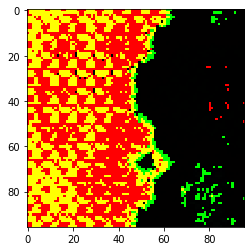

In [15]:
plt.imshow(train_inputs[1].astype('uint8'))
plt.show()

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_inputs, train_labels)).shuffle(10000000).batch(70)

test_ds = tf.data.Dataset.from_tensor_slices(
    (val_inputs, val_labels, val_true_weights)).batch(1)
#for element in train_ds:
#    print(element)

In [125]:
@tf.custom_gradient
def compute_probs_op(x):
    
    x_reshaped = tf.reshape(x, [-1, 144])
    #print(x_reshaped.shape)
        
    world_weights = tf.tensordot(x_reshaped, samples_tf, axes=1)
    #print(world_weights)
    #d = self.samples
    variable_weights = tf.tensordot(samples_tf, tf.transpose(world_weights), axes=1)
    #print(variable_weights)
    # here we need to insert the sampling part
        
    Z = tf.reduce_sum(world_weights, 1)
    #print(Z)
        
    normalized_variable_weights = tf.math.divide(variable_weights, Z)
    #print(normalized_variable_weights)
             
    result = tf.reshape(normalized_variable_weights, [-1, 12, 12])
    #print(result)
        
    def custom_grad(dy):
        grad = dy
        return grad
    
    return result, custom_grad

In [126]:
class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output



def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


class ResNet18(tf.keras.Model):
    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same",
                                            use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")
        self.layer1 = make_basic_block_layer(filter_num=64, blocks=2)

        output_shape = (int(12), int(12))
        self.adaptivepool = tfa.layers.AdaptiveAveragePooling2D(output_shape)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.adaptivepool(x)
        output = tf.math.reduce_mean(x, axis=3)
        
        return output
    
    
class ResNet18Inference(tf.keras.Model):
    def __init__(self):
        super(ResNet18Inference, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same",
                                            use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")
        self.layer1 = make_basic_block_layer(filter_num=64, blocks=2)

        output_shape = (int(12), int(12))
        self.adaptivepool = tfa.layers.AdaptiveAveragePooling2D(output_shape)

        
    def set_sample_matrix(self, samples_in):
        self.samples = tf.transpose(tf.cast(samples_in, tf.float32))
        print(self.samples.shape)
        
    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.adaptivepool(x)
        x_logit = tf.math.reduce_mean(x, axis=3)
        x_prob = tf.math.sigmoid(-x_logit)
        
        inference_x = compute_probs_op(-x_logit)
        
        return x_prob, x_logit, inference_x

In [127]:
model_inference = ResNet18Inference()
model_inference.set_sample_matrix(samples_binary)

(144, 100000)


In [128]:
x = model_inference(train_inputs[1:2])

In [129]:
x

(<tf.Tensor: shape=(1, 12, 12), dtype=float32, numpy=
 array([[[0.4353631 , 0.43278903, 0.4366324 , 0.43895686, 0.43986812,
          0.43906167, 0.42274982, 0.40161264, 0.43634015, 0.44437823,
          0.4438726 , 0.45040503],
         [0.4384003 , 0.4354101 , 0.4385936 , 0.43984175, 0.44153553,
          0.43781373, 0.40392026, 0.4159014 , 0.4297735 , 0.4326549 ,
          0.43092716, 0.44436863],
         [0.44181007, 0.4381663 , 0.4406692 , 0.44256508, 0.44393685,
          0.42475995, 0.3946631 , 0.42627493, 0.4431206 , 0.45439348,
          0.45409933, 0.46224594],
         [0.44329005, 0.43951884, 0.44241828, 0.444152  , 0.4430768 ,
          0.41206005, 0.41668186, 0.43314895, 0.45674744, 0.4649428 ,
          0.4644465 , 0.4699495 ],
         [0.44433254, 0.43895376, 0.44165018, 0.443328  , 0.44123295,
          0.41006476, 0.42405507, 0.43926486, 0.46193004, 0.46485218,
          0.46189982, 0.46747547],
         [0.44394317, 0.43857977, 0.44003272, 0.44083178, 0.43746543,
 

In [130]:
x[1].shape

TensorShape([1, 12, 12])

In [131]:
train_labels[1]

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [132]:
train_step(train_inputs[1:2], train_labels[1:2])

In [133]:
dijkstra(tf.math.exp(x[1][0]))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [134]:
loss_object_0 = tf.keras.losses.BinaryCrossentropy(from_logits=False)
loss_object_1 = tf.keras.losses.BinaryCrossentropy(from_logits=False)

optimizer = tf.keras.optimizers.Adam()

In [135]:
# custom accuracy function
class SameSolutionAccuracy(tf.keras.metrics.Metric):

    def __init__(self, name='same_solution_accuracy', **kwargs):
        super(SameSolutionAccuracy, self).__init__(name=name, **kwargs)
        self.same_solutions = self.add_weight(name='tp', initializer='zeros')
        self.counter = self.add_weight(name='counter', initializer='zeros')

    def update_state(self, y_true, y_pred, cost_matrix):
        y_true = tf.cast(y_true, tf.bool)
        # apply the combinatorial solver (dijkstra) // parallel not possible in eager mode (python function!)
        y_pred = tf.cast(tf.map_fn(dijkstra, y_pred), tf.bool)
        
        # compute the cost of the shortest path
        
        # invert vector (used if representation of true paths is 0-based)
        #y_true = tf.cast(tf.math.logical_not(y_true), tf.float32)
        #y_pred = tf.cast(tf.math.logical_not(y_pred), tf.float32)
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        #print(y_true)
        #print(y_pred)
        
        y_true = tf.reshape(y_true, [-1, 144])
        y_pred = tf.reshape(y_pred, [-1, 144])
        cost_matrix = tf.cast(cost_matrix, tf.float32)
        cost_matrix = tf.reshape(cost_matrix, [-1, 144])
        
        #print(y_true.shape)
        
        y_true_cost = tf.math.reduce_sum(cost_matrix * y_true, 1)
        y_pred_cost = tf.math.reduce_sum(cost_matrix * y_pred, 1)
        
        print(y_true_cost)
        print(y_pred_cost)
        
        # True if the cost is the same
        equal_values = tf.cast(tf.math.less_equal(y_pred_cost, y_true_cost), tf.float32)
        print(equal_values)
        sum_correct_in_batch = tf.math.reduce_sum(equal_values)
        print(sum_correct_in_batch)
        print(y_true.shape[0])

        self.same_solutions.assign_add(sum_correct_in_batch)
        self.counter.assign_add(y_true.shape[0])
        
        
        print("---")

    def result(self):
        return self.same_solutions/self.counter

In [136]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
train_samesol = SameSolutionAccuracy()

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
test_samesol = SameSolutionAccuracy()

In [137]:
#@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model_inference(images, training=True)
        loss = loss_object_0(labels, predictions[2])
    gradients = tape.gradient(loss, model_inference.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_inference.trainable_variables))

    train_loss(loss_object_0(labels, predictions[2]))
    train_accuracy(labels,  predictions[0])
    #train_samesol(labels,predictions)

In [138]:
#@tf.function
def test_step(images, labels, cost_matrix):
    predictions = model_inference(images, training=False)
    t_loss = loss_object_0(labels, predictions[0])

    test_loss(t_loss)
    test_accuracy(labels, -predictions[0])
    #print(labels)
    test_samesol(labels, predictions[1], cost_matrix)

In [ ]:
for epoch in range(50):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, SameSol: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100,
                        test_samesol.result()))    

In [ ]:
test_loss.reset_states()
test_accuracy.reset_states()
test_samesol.reset_states()

for test_images, test_labels, cost_matrix in test_ds:
    test_step(test_images, test_labels, cost_matrix)
    
template = 'Epoch {}, Test Loss: {}, Test Accuracy: {}, SameSol: {}'
print(template.format(epoch + 1,
                   test_loss.result(),
                   test_accuracy.result() * 100,
                   test_samesol.result()))

tf.Tensor([16.798828], shape=(1,), dtype=float32)
tf.Tensor([28.805664], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
1
---
tf.Tensor([47.103516], shape=(1,), dtype=float32)
tf.Tensor([50.506836], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
1
---
tf.Tensor([33.89746], shape=(1,), dtype=float32)
tf.Tensor([42.396484], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
1
---
tf.Tensor([12.798828], shape=(1,), dtype=float32)
tf.Tensor([13.199219], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
1
---
tf.Tensor([78.02246], shape=(1,), dtype=float32)
tf.Tensor([78.42285], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
1
---
tf.Tensor([26.998047], shape=(1,), dtype=float32)
tf.Tenso

In [ ]:
val_labels[1]

In [ ]:
x = model(val_inputs[0:2])
x[1]
#1-dijkstra(x[1]).shortest_path